In [3]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

In [4]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

I0000 00:00:1738786507.152641 39714094 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1738786507.180101 39714381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1738786507.188555 39714379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [5]:
video_path = '../test.mp4'
cap = cv2.VideoCapture(video_path)

In [6]:
# Read the first frame (frame 0)
ret, frame = cap.read()
if not ret:
    print("Failed to read the video.")
    exit()


In [7]:
cap.release()
cv2.destroyAllWindows()

In [8]:
# Convert the frame to RGB
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Process the frame with MediaPipe Hands
results = hands.process(frame_rgb)

# Initialize lists to store finger tip coordinates for each hand
hand1_finger_tips = []
hand2_finger_tips = []

W0000 00:00:1738786511.608862 39714378 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [9]:
if results.multi_hand_landmarks:
    for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
        # Extract landmarks for each hand
        landmarks = hand_landmarks.landmark
        
        # Indices for the finger tips (MediaPipe provides 21 landmarks per hand)
        # Thumb: 4, Index: 8, Middle: 12, Ring: 16, Pinky: 20
        finger_tip_indices = [4, 8, 12, 16, 20]
        
        # Get the (x, y) coordinates of the finger tips
        finger_tips = []
        for idx in finger_tip_indices:
            x = landmarks[idx].x * frame.shape[1]  # Scale x to image width
            y = landmarks[idx].y * frame.shape[0]  # Scale y to image height
            finger_tips.append((x, y))
        
        # Store the finger tips in the appropriate list
        if i == 0:
            hand1_finger_tips = finger_tips
        elif i == 1:
            hand2_finger_tips = finger_tips

else:
    print("No hands detected in frame 0.")

cap.release()

Hand 1 Finger Tips Coordinates:
[[650.64880371 196.17670298]
 [695.47607422 183.01712036]
 [637.11990356 243.89719248]
 [628.41602325 277.96691179]
 [630.24879456 309.94802713]]
Hand 2 Finger Tips Coordinates:
[[688.43811035 366.99850559]
 [750.98999023 211.81413174]
 [731.77192688 459.55381393]
 [755.32325745 479.83260155]
 [785.36575317 475.4061842 ]]


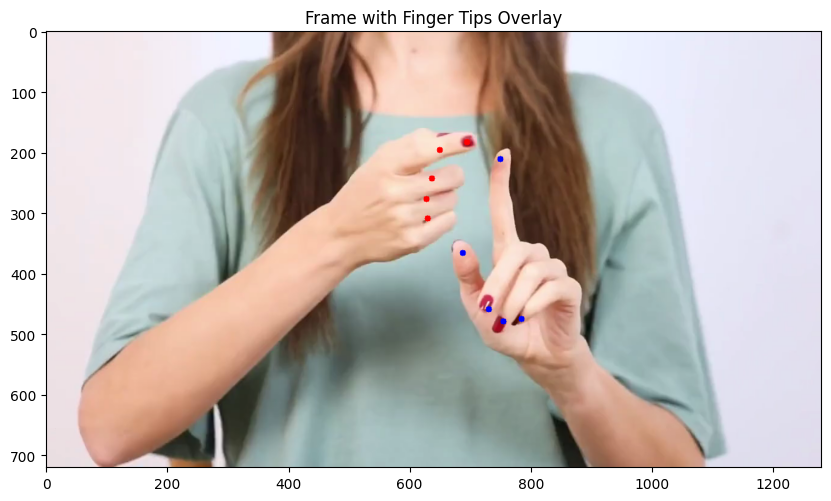

In [10]:
# Convert the finger tips to NumPy arrays
hand1_finger_tips = np.array(hand1_finger_tips)
hand2_finger_tips = np.array(hand2_finger_tips)

# Print the coordinates
print("Hand 1 Finger Tips Coordinates:")
print(hand1_finger_tips)
print("Hand 2 Finger Tips Coordinates:")
print(hand2_finger_tips)

overlay_image = frame.copy()

for (x, y) in hand1_finger_tips:
    x, y = int(x), int(y)  # Explicitly convert to integers
    cv2.circle(overlay_image, (x, y), radius=5, color=(0, 0, 255), thickness=-1)  # Red points

# Draw finger tips for Hand 2 (in blue)
for (x, y) in hand2_finger_tips:
    x, y = int(x), int(y)  # Explicitly convert to integers
    cv2.circle(overlay_image, (x, y), radius=5, color=(255, 0, 0), thickness=-1)  # Blue points

# Visualize the results using matplotlib
plt.figure(figsize=(10, 10))

# # Display the original frame
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# plt.title("Original Frame")

# Display the frame with overlaid finger tips
# plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title("Frame with Finger Tips Overlay")
plt.show()

In [11]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [12]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [13]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [14]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [23]:
def extract_all_frames(video_path, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save every frame
        frame_filename = os.path.join(output_dir, f"{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames to {output_dir}")

input_dir = os.path.dirname(video_path)
video_name = os.path.splitext(os.path.basename(video_path))[0]
video_dir = os.path.join(input_dir, f"{video_name}_dir")
extract_all_frames(video_path, video_dir)

Extracted 210 frames to ../test_dir


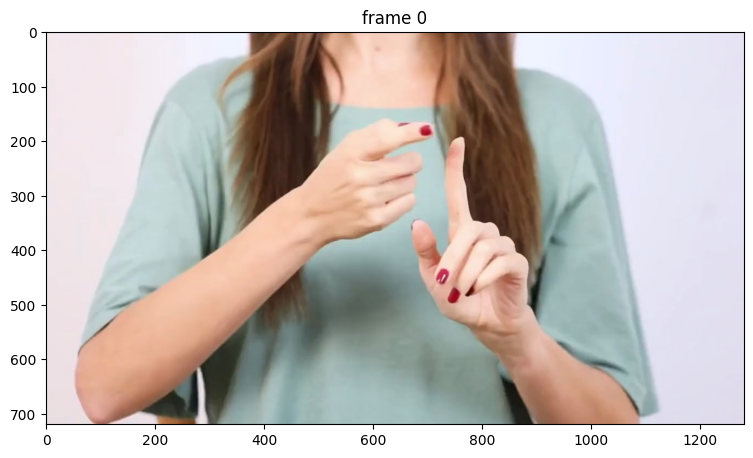

In [24]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [25]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 210/210 [00:03<00:00, 52.97it/s]


In [32]:
predictor.reset_state(inference_state)

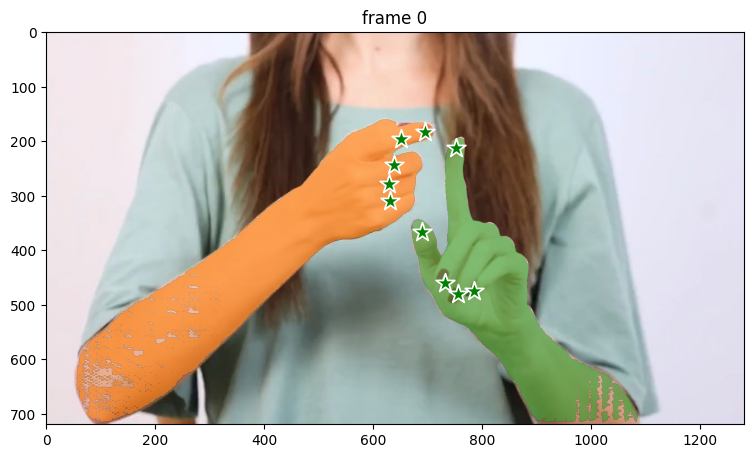

In [33]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id_hand1 = 1  # give a unique id to each object we interact with (it can be any integers)
ann_obj_id_hand2 = 2  # give a unique id to each object we interact with (it can be any integers)
prompts = {}

points = np.array(hand1_finger_tips, dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,1,1,1,1], np.int32)
prompts[ann_obj_id_hand1] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id_hand1,
    points=points,
    labels=labels,
)

points = np.array(hand2_finger_tips, dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,1,1,1,1], np.int32)
prompts[ann_obj_id_hand2] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id_hand2,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

propagate in video: 100%|██████████| 210/210 [1:36:00<00:00, 27.43s/it]


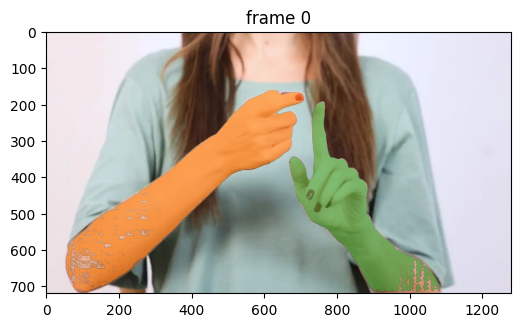

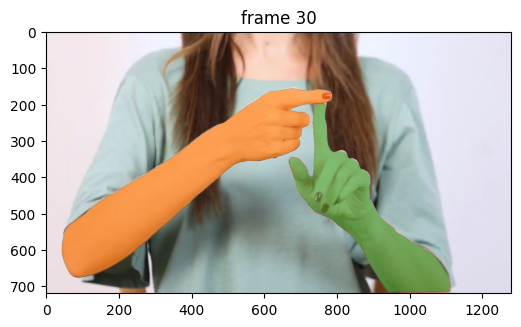

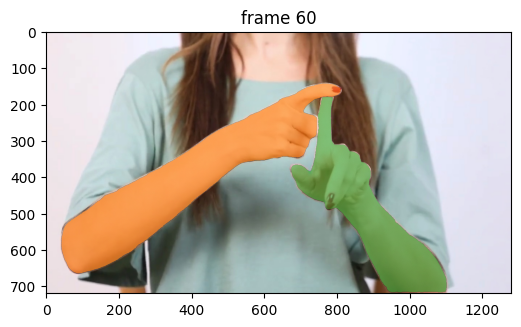

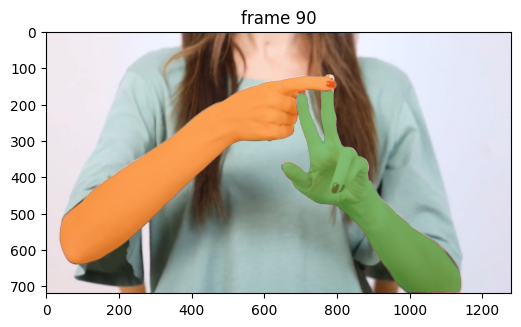

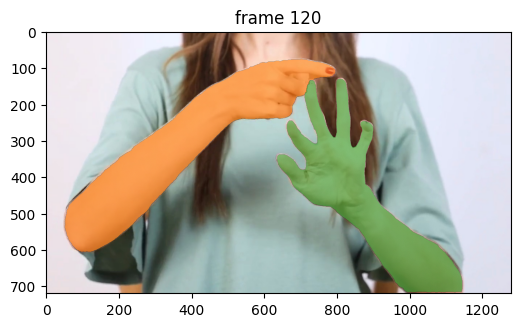

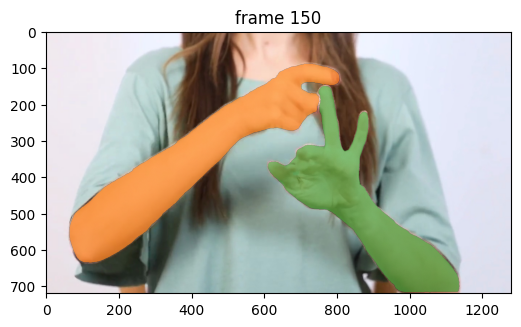

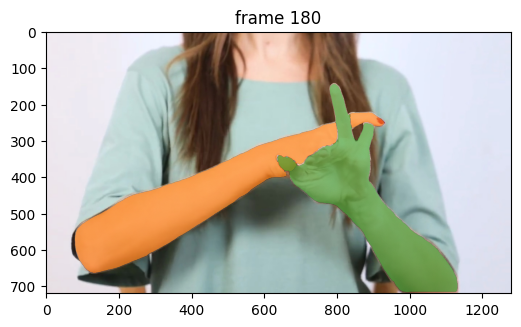

In [34]:
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [36]:
import imageio

# Assuming video_segments, frame_names, and video_dir are already defined

vis_frame_stride = 30
output_video_path = "output_video.mp4"
temp_frame_dir = "temp_frames"
os.makedirs(temp_frame_dir, exist_ok=True)

# List to store the paths of the generated frames
frame_paths = []

for out_frame_idx in range(0, len(frame_names)):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    
    # Save the frame with the mask applied
    frame_path = os.path.join(temp_frame_dir, f"frame_{out_frame_idx:04d}.png")
    plt.savefig(frame_path)
    plt.close()
    
    # Append the frame path to the list
    frame_paths.append(frame_path)

# Compile the frames into a video
with imageio.get_writer(output_video_path, fps=30) as writer:
    for frame_path in frame_paths:
        image = imageio.imread(frame_path)
        writer.append_data(image)

# # Optionally, remove the temporary frames
# for frame_path in frame_paths:
#     os.remove(frame_path)
# os.rmdir(temp_frame_dir)

print(f"Video saved to {output_video_path}")

/var/folders/p4/8ylcj22s0jscrsjzklw073mm0000gn/T/ipykernel_34724/221752418.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)
python(39217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Video saved to output_video.mp4
